In [6]:
using Oceananigans
using JLD2
using CairoMakie
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian
using OffsetArrays: no_offset_view
using CairoMakie.Colors

In [7]:
runnames = ["Ri000", "Ri010", "Ri020", "Ri030"]
foldernames = map(runnames) do runname
    "../../../scratch/filament-instability/$runname"
end
runlabels = [L"0.00", L"0.10", L"0.20", L"0.30"]
legendtitle = L"Ri";

# Base state potential vorticity and Richardson number

# Three snapshots of the evolution

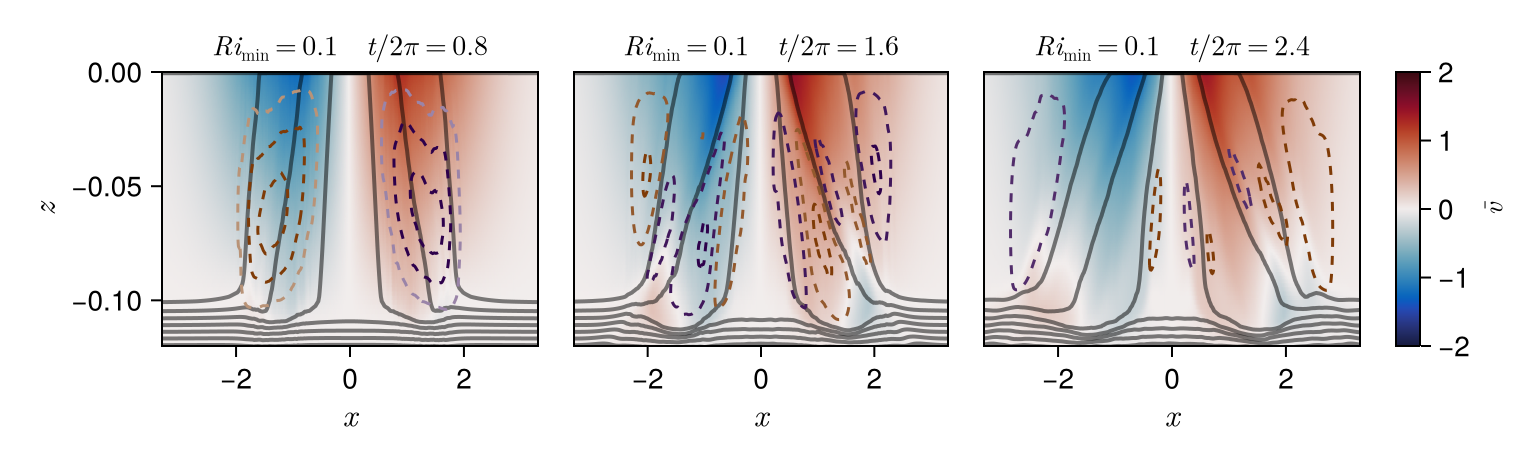

In [8]:
b_levels = range(-300, -227, 12)
ψ_levels = range(-0.0045, 0.0045, 6)
ψ_colors = [
    to_colormap(:PuOr)[end], 
    to_colormap(:PuOr)[end], 
    to_colormap(:PuOr)[end], 
    RGB(1, 1, 1), 
    to_colormap(:PuOr)[1], 
    to_colormap(:PuOr)[1],
    to_colormap(:PuOr)[1]
]

fig = let
    foldername = foldernames[2]
    times = [0.8, 1.6, 2.4] # t/2π
    init_time, run_time, sp = jldopen("$foldername/parameters.jld2") do file
        file["parameters/init_time"], file["parameters/run_time"], file["parameters/simulation"]
    end
    xs, zs, vs, bs, ψs = jldopen("$foldername/DFM.jld2") do file

        iterations = keys(file["timeseries/t"])
        ts = map(iteration->(file["timeseries/t/$iteration"] - init_time)/(2π), iterations)
        iterations = map(t->iterations[argmin(abs.(ts .- t))], times)

        vs = map(iteration->file["timeseries/v_dfm/$iteration"][:, 1, :], iterations)
        bs = map(iteration->file["timeseries/b_dfm/$iteration"][:, 1, :], iterations)
        ψs = map(iteration->file["timeseries/ψ/$iteration"][:, 1, :], iterations)
        vs = map(no_offset_view, vs)
        bs = map(no_offset_view, bs)
        ψs = map(no_offset_view, ψs)

        # All of these fields are on Center, Nothing, Center
        xs = no_offset_view(file["grid/xᶜᵃᵃ"])
        zs = no_offset_view(file["grid/zᵃᵃᶜ"])
        xs, zs, vs, bs, ψs
    end

    fig = Figure(; size=(1000, 300)./1.3, fontsize=14)
    axis_kwargs = (; xlabel=L"x", ylabel=L"z", limits=(-3.3sp.L, 3.3sp.L, -1.2sp.H, 0), xlabelsize=16, ylabelsize=16)
    axs = map(enumerate(times)) do (i, t)
        Axis(fig[1, i]; axis_kwargs..., title=L"Ri_\text{min}=0.1\quad t/2\pi=%$(round(t; digits=1))")
    end
    cmax = maximum(maximum.(abs, vs))
    cmax=2
    hideydecorations!.(axs[2:end])
    hts = map(axs, vs, bs, ψs) do ax, v, b, ψ
        ht = heatmap!(ax, xs, zs, v, colormap=:balance, colorrange=(-cmax, cmax))
        contour!(ax, xs, zs, b; color=(:black, 0.5), levels=b_levels, linewidth=2)
        contour!(ax, xs, zs, ψ; colormap=ψ_colors, linestyle=:dash, levels=ψ_levels, linewidth=1.5)
        ht
    end
    Colorbar(fig[1, 4], hts[1]; label=L"\overline{v}")
    fig
end
#save("../output/paper_figures/v_figure.png", fig; px_per_unit=2)
fig

# TKE production terms
The filament is unstable and the initial evolution is an instability that quickly extracts energy from the thermal wind vertical shear. Before the buoyancy flux rises, the filament also has a constant background VSP.

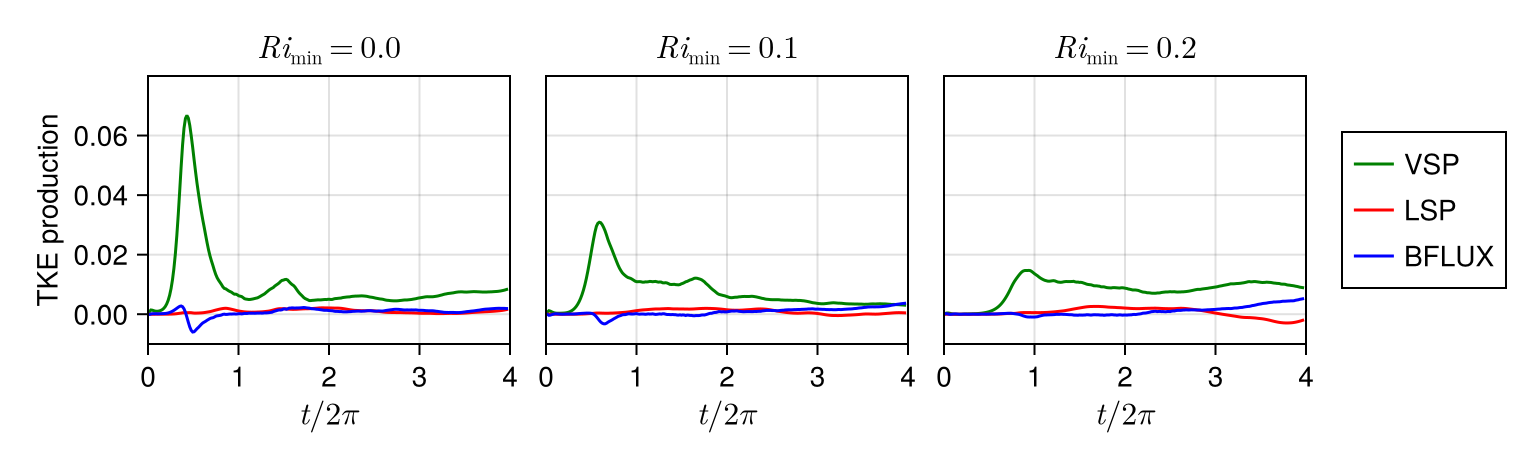

In [9]:
fig = let foldernames = foldernames[1:3]
    fig = Figure(; size=(1000, 300)./1.3, fontsize=14)
    map(enumerate(foldernames)) do (i, foldername)
        
        # Get parameters 
        init_time, run_time, sp = jldopen("$foldername/parameters.jld2") do file
            file["parameters/init_time"], file["parameters/run_time"], file["parameters/simulation"]
        end
        
        # Compute the integrals
        ts, VSP, LSP, BFLUX = jldopen("$foldername/TKE.jld2") do file
            iterations = keys(file["timeseries/t"])
            ts = map(iteration->(file["timeseries/t/$iteration"] - init_time)/(2π), iterations)
            Δz = reshape(file["grid/Δzᵃᵃᶜ"][1:sp.Nz], 1, sp.Nz)
            Ly = file["grid/Ly"]
            Δx = file["grid/Δxᶜᵃᵃ"]
            VSP = map(iterations) do iteration
                sum(file["timeseries/VSP/$iteration"][:, 1, 1:sp.Nz] .* Δz) * Δx * Ly
            end
            LSP = map(iterations) do iteration
                sum(file["timeseries/LSP/$iteration"][:, 1, 1:sp.Nz] .* Δz) * Δx * Ly
            end
            BFLUX = map(iterations) do iteration
                sum(file["timeseries/BFLUX/$iteration"][:, 1, 1:sp.Nz] .* Δz) * Δx * Ly
            end
            ts, VSP, LSP, BFLUX
        end
        
        # Plot
        ax = Axis(fig[1, i];
            xlabel=L"t / 2\pi", 
            ylabel="TKE production",
            title=L"Ri_\text{min}=%$(round(sp.Ri, digits=2))",
            limits=(0, 4, -0.01, 0.08),
            xlabelsize=16, ylabelsize=14, titlesize=16
        )
        lns = [
            lines!(ax, ts, VSP; color=:green),
            lines!(ax, ts, LSP; color=:red),
            lines!(ax, ts, BFLUX; color=:blue)
        ]
        
        i != 1 && hideydecorations!(ax, grid=false)
        
        # Add a legend for the last one
        i == length(foldernames) && Legend(fig[1, i+1], lns, ["VSP", "LSP", "BFLUX"])
        
    end
    fig
end
#save("../output/paper_figures/TKE_figure.png", fig; px_per_unit=2)
fig

# Potential vorticity
The volume of $q<0$ is destroyed slowly. The initial instability does not seem to destroy much PV, but the filament is still symmetrically unstable. The constant loss of unstable fluid, as well at the VSP in the previous figure are indicative of SI within the filament

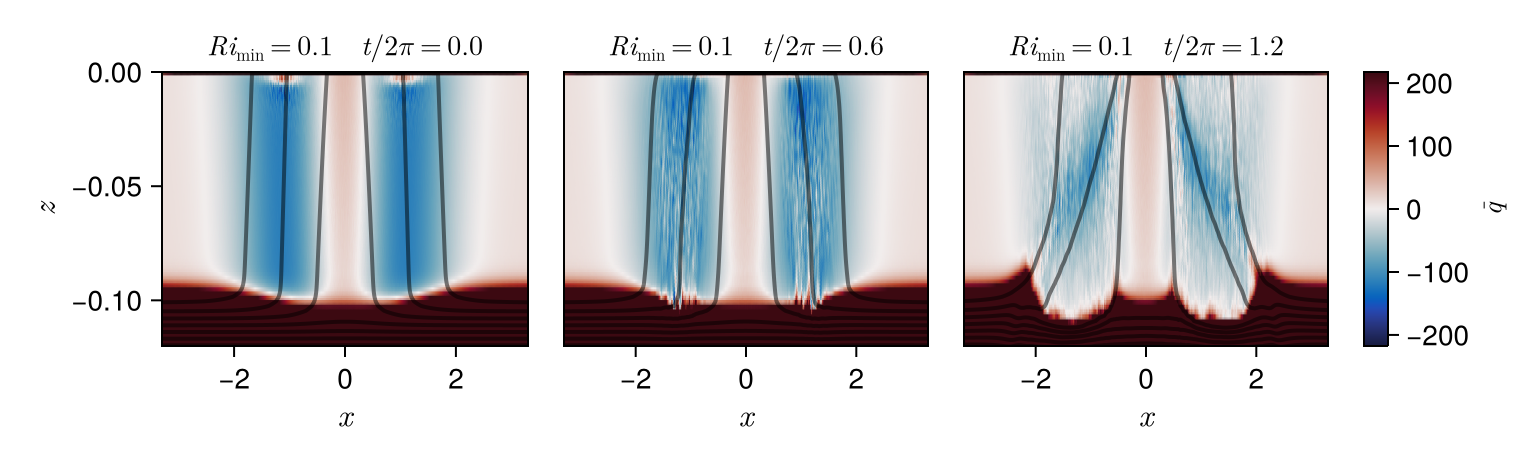

In [49]:
b_levels = range(-300, -227, 12)
ψ_levels = range(-0.0045, 0.0045, 6)
ψ_colors = [
    to_colormap(:PuOr)[end], 
    to_colormap(:PuOr)[end], 
    to_colormap(:PuOr)[end], 
    RGB(1, 1, 1), 
    to_colormap(:PuOr)[1], 
    to_colormap(:PuOr)[1],
    to_colormap(:PuOr)[1]
]

fig = let
    foldername = foldernames[2]
    times = [0.01, 0.6, 1.2] # t/2π
    init_time, run_time, sp = jldopen("$foldername/parameters.jld2") do file
        file["parameters/init_time"], file["parameters/run_time"], file["parameters/simulation"]
    end
    xs, zs, bs, ψs = jldopen("$foldername/DFM.jld2") do file

        iterations = keys(file["timeseries/t"])
        ts = map(iteration->(file["timeseries/t/$iteration"] - init_time)/(2π), iterations)
        iterations = map(t->iterations[argmin(abs.(ts .- t))], times)
        
        bs = map(iteration->file["timeseries/b_dfm/$iteration"][:, 1, :], iterations)
        ψs = map(iteration->file["timeseries/ψ/$iteration"][:, 1, :], iterations)
        bs = map(no_offset_view, bs)
        ψs = map(no_offset_view, ψs)

        # All of these fields are on Center, Nothing, Center
        xs = no_offset_view(file["grid/xᶜᵃᵃ"])
        zs = no_offset_view(file["grid/zᵃᵃᶜ"])
        xs, zs, bs, ψs
    end
    qs = jldopen("$foldername/PV.jld2") do file

        iterations = keys(file["timeseries/t"])
        ts = map(iteration->(file["timeseries/t/$iteration"] - init_time)/(2π), iterations)
        iterations = map(t->iterations[argmin(abs.(ts .- t))], times)
        
        qs = map(iteration->file["timeseries/q_dfm/$iteration"][:, 1, :], iterations)
        qs = map(no_offset_view, qs)

        # All of these fields are on Center, Nothing, Center
        xs = no_offset_view(file["grid/xᶜᵃᵃ"])
        zs = no_offset_view(file["grid/zᵃᵃᶜ"])
        qs
    end

    fig = Figure(; size=(1000, 300)./1.3, fontsize=14)
    axis_kwargs = (; xlabel=L"x", ylabel=L"z", limits=(-3.3sp.L, 3.3sp.L, -1.2sp.H, 0), xlabelsize=16, ylabelsize=16)
    axs = map(enumerate(times)) do (i, t)
        Axis(fig[1, i]; axis_kwargs..., title=L"Ri_\text{min}=%$(round(sp.Ri; digits=1))\quad t/2\pi=%$(round(t; digits=1))")
    end
    cmax = maximum(maximum.(-qs))
    
    hideydecorations!.(axs[2:end])
    hts = map(axs, qs, bs, ψs) do ax, q, b, ψ
        ht = heatmap!(ax, xs, zs, q, colormap=:balance, colorrange=(-cmax, cmax))
        contour!(ax, xs, zs, b; color=(:black, 0.5), levels=b_levels, linewidth=2)
        #contour!(ax, xs, zs, q; color=(:blue, 0.5), levels=[0], linewidth=2)
        #contour!(ax, xs, zs, ψ; colormap=ψ_colors, linestyle=:dash, levels=ψ_levels, linewidth=1.5)
        ht
    end
    Colorbar(fig[1, 4], hts[1]; label=L"\overline{q}")
    fig
end
#save("../output/paper_figures/v_figure.png", fig; px_per_unit=2)
fig

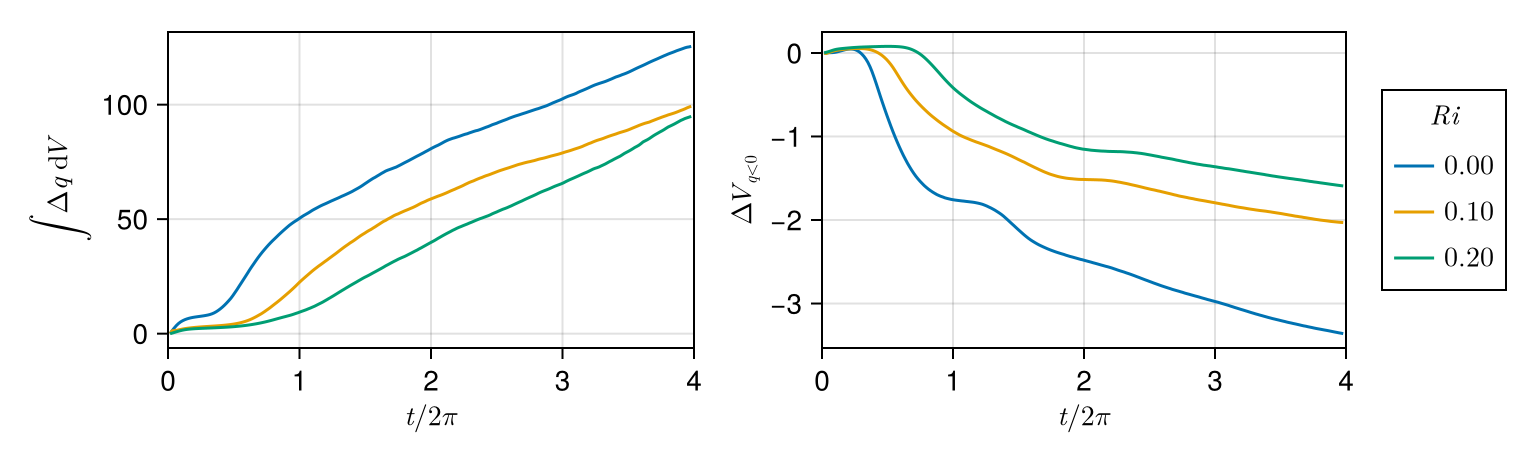

In [43]:
fig = let foldernames = foldernames[1:3]
    from_dfm = false
    fig = Figure(; size=(1000, 300)./1.3)
    # First figure is a plot of integrated PV
    ax = Axis(fig[1, 1]; xlabel=L"t / 2\pi", ylabel=L"\int \Delta q \; \text{d}\!V", limits=((0, 4), nothing))
    lns = map(foldernames) do foldername
        init_time, run_time, sp = jldopen("$foldername/parameters.jld2") do file
            file["parameters/init_time"], file["parameters/run_time"], file["parameters/simulation"]
        end
        
        ts, q = jldopen("$foldername/PV.jld2") do file
            iterations = keys(file["timeseries/t"])
            ts = map(iteration->(file["timeseries/t/$iteration"] - init_time)/(2π), iterations)
            init_iter = findfirst(ts .>= 0) + 1
            Δz = reshape(file["grid/Δzᵃᵃᶜ"][1:sp.Nz], 1, sp.Nz)
            Ly = file["grid/Ly"] 
            Δx = file["grid/Δxᶜᵃᵃ"]
            q = map(iterations) do iteration
                sum(file["timeseries/q$(from_dfm ? "_from" : "")_dfm/$iteration"][1:sp.Nx, 1, 1:sp.Nz] .* Δz) * Δx * Ly
            end
            ts[init_iter:end], q[init_iter:end] .- q[init_iter]
        end
        lines!(ax, ts, q)
    end
    ax = Axis(fig[1, 2]; xlabel=L"t / 2\pi", ylabel=L"\Delta\! V_{q<0}", limits=((0, 4), nothing))
    # Second is the total volume of q<0 fluid
    lns = map(foldernames) do foldername
        init_time, run_time, sp = jldopen("$foldername/parameters.jld2") do file
            file["parameters/init_time"], file["parameters/run_time"], file["parameters/simulation"]
        end
        
        ts, q_vol = jldopen("$foldername/PV.jld2") do file
            iterations = keys(file["timeseries/t"])
            ts = map(iteration->(file["timeseries/t/$iteration"] - init_time)/(2π), iterations)
            init_iter = findfirst(ts .>= 0) + 1
            q_vol = map(iterations) do iteration
                file["timeseries/q_vol$(from_dfm ? "_from_dfm" : "")/$iteration"][1]
            end
            ts[init_iter:end], q_vol[init_iter:end] .- q_vol[init_iter]
        end
        lines!(ax, ts, q_vol)
    end
    Legend(fig[1, 3], lns, runlabels[1:3], legendtitle)
    fig
end
#save("../output/paper_figures/PV_figure.png", fig; px_per_unit=2)
fig

# Surface buoyancy gradient

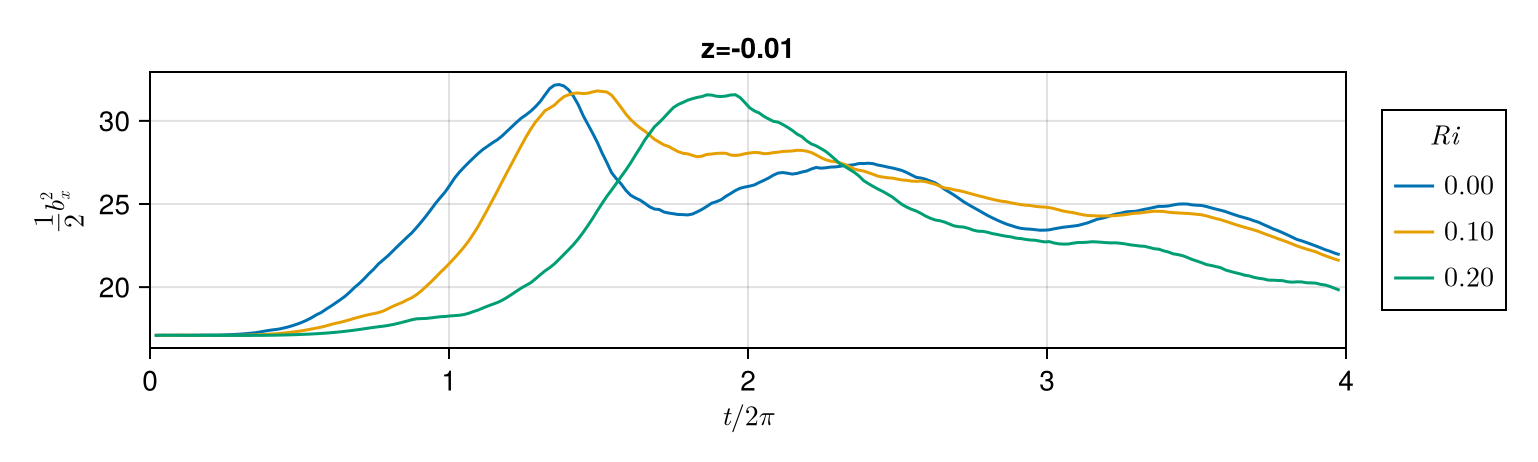

In [50]:
fig = let foldernames = foldernames[1:3]
    fig = Figure(; size=(1000, 300)./1.3)
    z = -0.01
    ax = Axis(fig[1, 1]; xlabel=L"t / 2\pi", ylabel=L"\frac{1}{2}b_x^2", limits=((0, 4), nothing), title="z=$z")
    lns = map(foldernames) do foldername
        init_time, run_time, sp = jldopen("$foldername/parameters.jld2") do file
            file["parameters/init_time"], file["parameters/run_time"], file["parameters/simulation"]
        end
        ts, M² = jldopen("$foldername/DFM.jld2") do file
            iterations = keys(file["timeseries/t"])
            ts = map(iteration->(file["timeseries/t/$iteration"] - init_time)/(2π), iterations)
            init_iter = findfirst(ts .>= 0) + 1
            zs = file["grid/zᵃᵃᶜ"]
            Δz = reshape(file["grid/Δzᵃᵃᶜ"][1:sp.Nz], 1, sp.Nz)
            Ly = file["grid/Ly"] 
            Δx = file["grid/Δxᶜᵃᵃ"]
            M² = map(iterations) do iteration
                let a = file["timeseries/b_dfm/$iteration"][1:sp.Nx, 1, argmin(abs.(zs .- z))]
                    mean(((circshift(a, -1) - circshift(a, 1)) / (2Δx)).^2) / 2
                end
            end
            ts[init_iter:end], M²[init_iter:end]
        end
        lines!(ax, ts, M²)
    end
    Legend(fig[1, 2], lns, runlabels[1:3], legendtitle)
    fig
end
save("../output/paper_figures/buoyancy_gradient_figure.png", fig; px_per_unit=2)
fig

# Vertical velocity slices and VSP
We show that slices of the initial instability are thin rolls parallel to isopycnals. Regions of saturated instability have large VSP. While the slices of the instability resemble SI, there is significant down-front variation, as shown in a horizontal slice

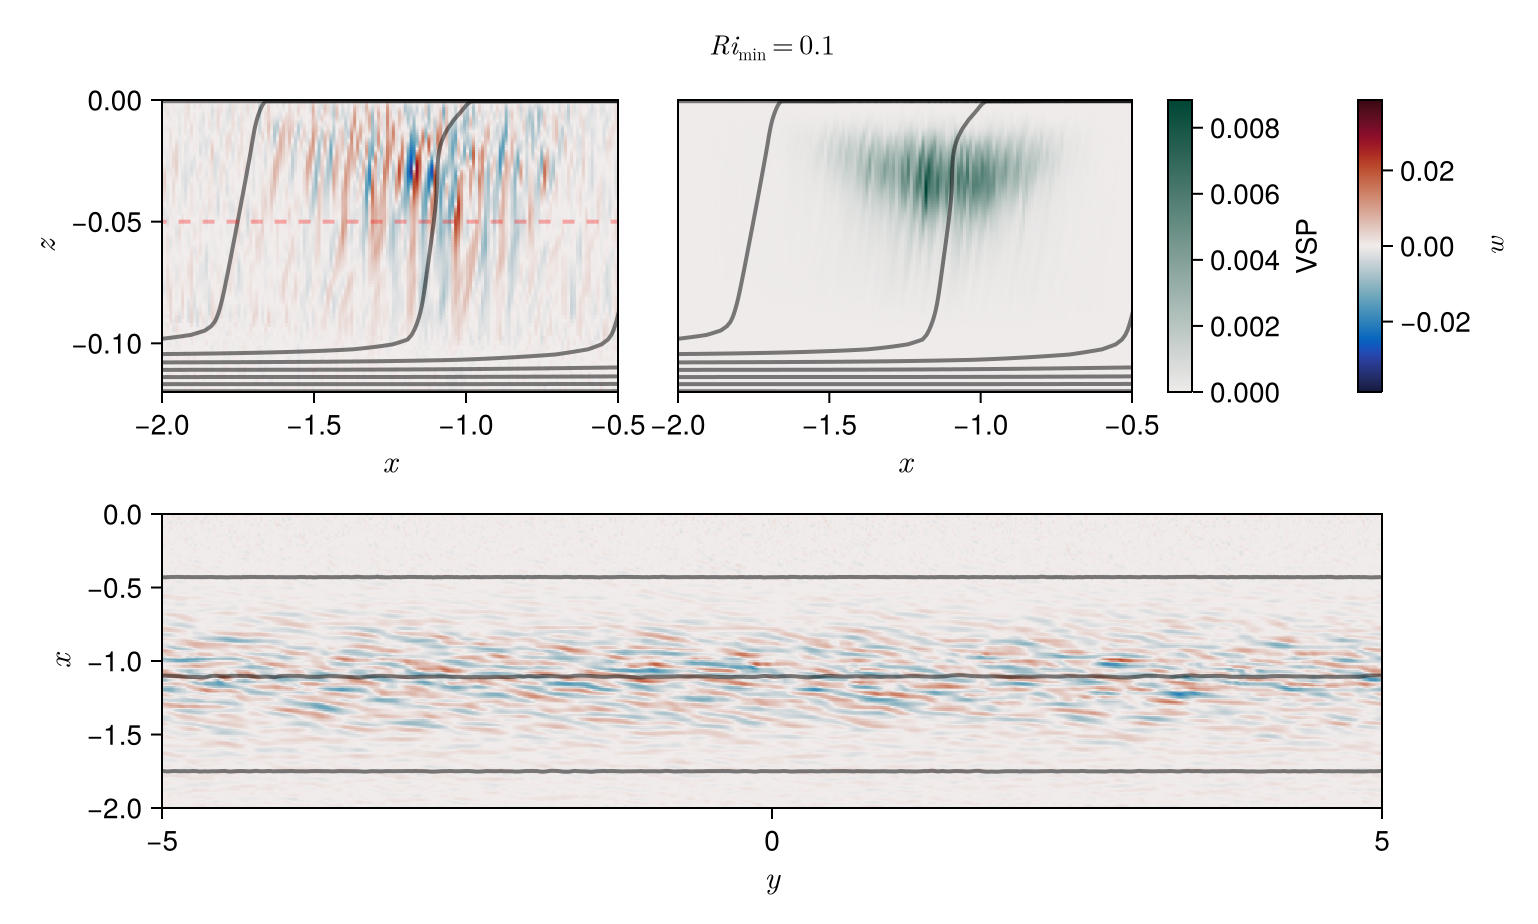

In [47]:
VSP_colors = [to_colormap(:balance)[127], to_colormap(:PuBuGn)[end]]
fig = let
    foldername = foldernames[2]
    t = 0.3 # t/2π
    z = -0.05
    init_time, run_time, sp = jldopen("$foldername/parameters.jld2") do file
        file["parameters/init_time"], file["parameters/run_time"], file["parameters/simulation"]
    end
    xsᶜ, ysᶜ, zsᶜ, zsᶠ, VSP = jldopen("$foldername/TKE.jld2") do file

        iterations = keys(file["timeseries/t"])
        ts = map(iteration->(file["timeseries/t/$iteration"] - init_time)/(2π), iterations)
        iteration = iterations[argmin(abs.(ts .- t))]

        VSP = no_offset_view(file["timeseries/VSP/$iteration"][:, 1, :])

        xsᶜ = no_offset_view(file["grid/xᶜᵃᵃ"])
        zsᶜ = no_offset_view(file["grid/zᵃᵃᶜ"])
        ysᶜ = no_offset_view(file["grid/yᵃᶜᵃ"])
        zsᶠ = no_offset_view(file["grid/zᵃᵃᶠ"])
        xsᶜ, ysᶜ, zsᶜ, zsᶠ, VSP
    end
    b_dfm = jldopen("$foldername/DFM.jld2") do file

        iterations = keys(file["timeseries/t"])
        ts = map(iteration->(file["timeseries/t/$iteration"] - init_time)/(2π), iterations)
        iteration = iterations[argmin(abs.(ts .- t))]

        no_offset_view(file["timeseries/b_dfm/$iteration"][:, 1, :])
    end
    w, w_slice, b, b_slice = jldopen("$foldername/output.jld2") do file

        iterations = keys(file["timeseries/t"])
        ts = map(iteration->(file["timeseries/t/$iteration"] - init_time)/(2π), iterations)
        iteration = iterations[argmin(abs.(ts .- t))]

        w = no_offset_view(file["timeseries/w/$iteration"][:, 512, :])
        w_slice = no_offset_view(file["timeseries/w/$iteration"])[:, :, argmin(abs.(zsᶠ .- z))]
        b = no_offset_view(file["timeseries/b/$iteration"][:, 1, :])
        b_slice = no_offset_view(file["timeseries/b/$iteration"])[:, :, argmin(abs.(zsᶠ .- z))]
        w, w_slice, b, b_slice
    end

    fig = Figure(; size=(1000, 600)./1.3, fontsize=14)
    axis_kwargs = (; xlabel=L"x", ylabel=L"z", limits=(-2sp.L, -0.5sp.L, -1.2sp.H, 0), xlabelsize=16, ylabelsize=16)

    ax_w = Axis(fig[1, 1]; axis_kwargs...)
    ax_VSP = Axis(fig[1, 2]; axis_kwargs...)

    cmax = maximum(abs, w_slice)
    ht_w = heatmap!(ax_w, xsᶜ, zsᶠ, w; colormap=:balance, colorrange=(-cmax, cmax))
    ht_VSP = heatmap!(ax_VSP, xsᶜ, zsᶜ, VSP; colormap=VSP_colors, colorrange=(0, maximum(VSP[:, 4:sp.Nz-1])))
    contour!(ax_VSP, xsᶜ, zsᶜ, b_dfm; color=(:black, 0.5), levels=b_levels, linewidth=2)
    contour!(ax_w, xsᶜ, zsᶜ, b_dfm; color=(:black, 0.5), levels=b_levels, linewidth=2)
    lines!(ax_w, [xsᶜ[1], xsᶜ[end]], [z, z]; color=(:red, 0.3), linestyle=:dash, linewidth=2)

    ax_w_slice = Axis(fig[2, 1:4]; xlabel=L"y", ylabel=L"x", limits=(-5sp.L, 5sp.L, -2sp.L, 0sp.L), xlabelsize=16, ylabelsize=16)
    w_slice = imfilter(w_slice, gaussian((1, 1)))
    heatmap!(ax_w_slice, ysᶜ, xsᶜ, transpose(w_slice); colormap=:balance, colorrange=(-cmax, cmax))
    contour!(ax_w_slice, ysᶜ, xsᶜ, transpose(b_slice); color=(:black, 0.5), levels=b_levels, linewidth=2)
    
    Colorbar(fig[1, 4], ht_w; label=L"w")
    Colorbar(fig[1, 3], ht_VSP; label="VSP")
    hideydecorations!.(ax_VSP)
    colgap!(fig.layout, 1, 30)
    #colgap!(fig.layout, 2, 30)
    Label(fig[0, :], L"Ri_\text{min}=%$(round(sp.Ri, digits=2)), t/2\pi=$t")
    fig
end
#save("../output/paper_figures/wVSP.png", fig; px_per_unit=2)
fig

# Streamfunction balance

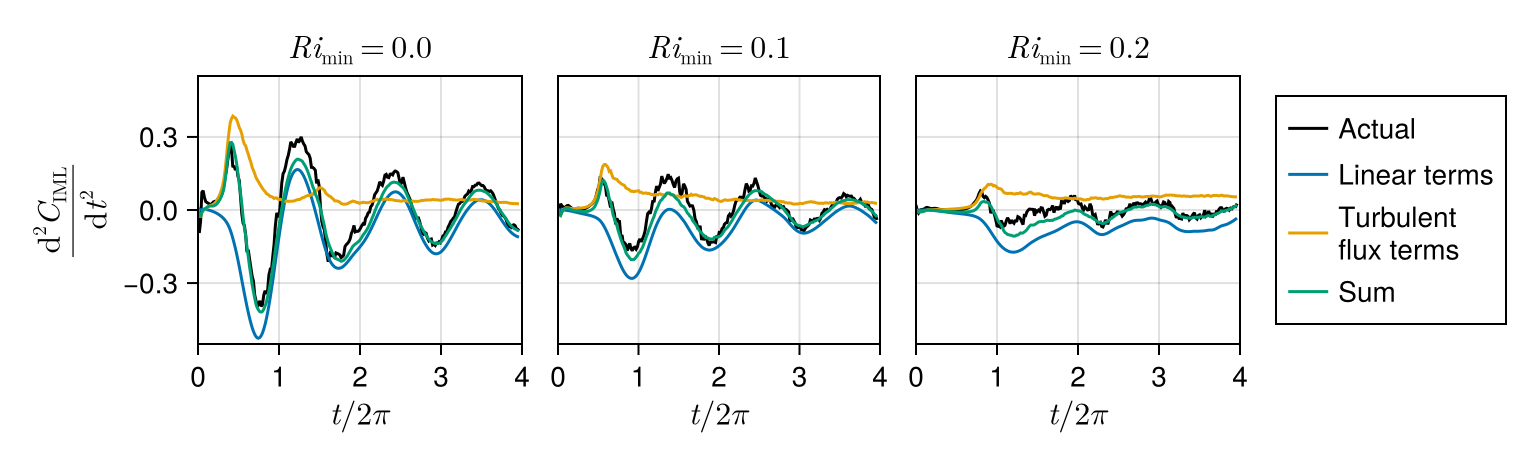

In [29]:
fig = let foldernames = foldernames[1:3]
    fig = Figure(; size=(1000, 300)./1.3, fontsize=14)
    map(enumerate(foldernames)) do (i, foldername)
        # Get parameters 
        init_time, run_time, sp = jldopen("$foldername/parameters.jld2") do file
            file["parameters/init_time"], file["parameters/run_time"], file["parameters/simulation"]
        end
        
        domain = (-sp.Lx, 0, -0.90sp.H, -0.1sp.H)
        
        # Compute the integrals
        ts, ∇²ψ_tt, Lψ = jldopen("$foldername/PSI_nice.jld2") do file
            iterations = keys(file["timeseries/t"])[2:end-1]
            ts = map(iteration->(file["timeseries/t/$iteration"] - init_time)/(2π), iterations)
            
            Δz = reshape(no_offset_view(file["grid/Δzᵃᵃᶜ"]), 1, sp.Nz + 6)
            Δx = file["grid/Δxᶜᵃᵃ"]
            
            Ly = file["grid/Ly"]
            
            x_inds = domain[1] .< no_offset_view(file["grid/xᶜᵃᵃ"]) .< domain[2]
            z_inds = domain[3] .< no_offset_view(file["grid/zᵃᵃᶜ"]) .< domain[4]
            
            Lψ = map(iterations) do iteration
                a = no_offset_view(file["timeseries/Lψ/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            ∇²ψ_tt = map(iterations) do iteration
                a = no_offset_view(file["timeseries/∇²ψ_tt/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            ts, ∇²ψ_tt, Lψ
        end
        F_nl, F_other, F_VSP, F_BFLUX = jldopen("$foldername/PSI_notnice.jld2") do file
            iterations = keys(file["timeseries/t"])[2:end-1]
            ts = map(iteration->(file["timeseries/t/$iteration"] - init_time)/(2π), iterations)
            
            Δz = reshape(no_offset_view(file["grid/Δzᵃᵃᶜ"]), 1, sp.Nz + 6)
            Δx = file["grid/Δxᶜᵃᵃ"]
            
            Ly = file["grid/Ly"]
            
            x_inds = domain[1] .< no_offset_view(file["grid/xᶜᵃᵃ"]) .< domain[2]
            z_inds = domain[3] .< no_offset_view(file["grid/zᵃᵃᶜ"]) .< domain[4]
            
            F_nl = map(iterations) do iteration
                a = no_offset_view(file["timeseries/F_nl/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            F_other = map(iterations) do iteration
                a = no_offset_view(file["timeseries/F_other/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            F_VSP = map(iterations) do iteration
                a = no_offset_view(file["timeseries/F_VSP/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            F_BFLUX = map(iterations) do iteration
                a = no_offset_view(file["timeseries/F_BFLUX/$iteration"])[:, 1, :] .* Δz
                sum(a[x_inds, z_inds]) * Δx
            end
            F_nl, F_other, F_VSP, F_BFLUX
        end
        
        # Plot
        ax = Axis(fig[1, i];
            xlabel=L"t / 2\pi", 
            ylabel=L"\frac{\text{d}^2 C_{\text{IML}}}{\text{d}t^2}",
            title=L"Ri_\text{min}=%$(round(sp.Ri, digits=2))",
            limits=(0, 4, -0.55, 0.55),
            xlabelsize=16, ylabelsize=16, titlesize=16
        )
        lns = [
            lines!(ax, ts, -∇²ψ_tt; color=:black),
            lines!(ax, ts, -Lψ),
            lines!(ax, ts, F_VSP + F_BFLUX + 0F_other),
            lines!(ax, ts, -Lψ + F_VSP + F_BFLUX + 0F_other)
        ]
        
        i != 1 && hideydecorations!(ax, grid=false)
        
        # Add a legend for the last one
        i == length(foldernames) && Legend(fig[1, i+1], lns, ["Actual", "Linear terms", "Turbulent\nflux terms", "Sum"])
        
    end
    fig
end
save("../output/paper_figures/streamfunction_evolution_figure.png", fig; px_per_unit=2)
fig

# Example base state

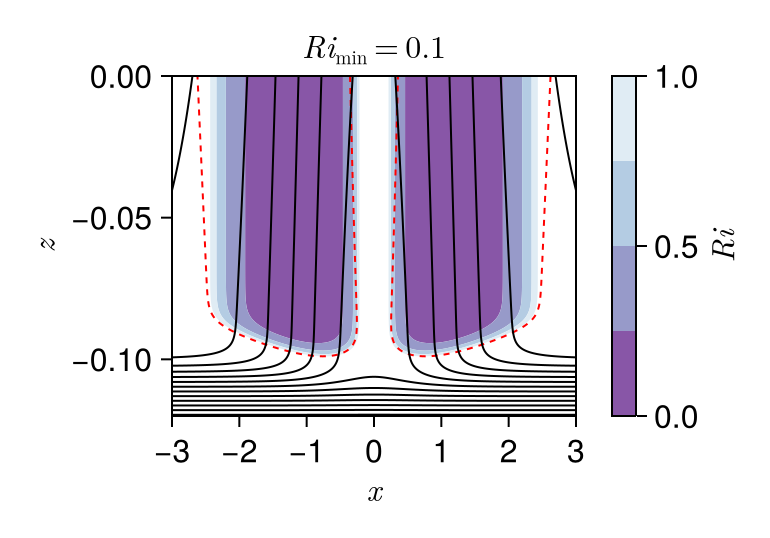

In [91]:
# Figure of the Richardson number

include("../src/filament_state.jl")
include("../src/parameters.jl")

sp = create_simulation_parameters(; Ro=0.8, Ri=0.1, α=1.5, verbose=false)
(b, v) = get_filament_state(sp; verbose=false)

@inline ∂xb(x, z) = (b(x+5e-8, z) - b(x-5e-8, z)) / 1e-7
@inline ∂zb(x, z) = (b(x, z+5e-8) - b(x, z-5e-8)) / 1e-7
@inline ∂xv(x, z) = (v(x+5e-8, z) - v(x-5e-8, z)) / 1e-7
@inline ∂zv(x, z) = (v(x, z+5e-8) - v(x, z-5e-8)) / 1e-7

@inline PV(x, z) = ∂zb(x, z) * (sp.f + ∂xv(x, z)) - ∂zv(x, z) * ∂xb(x, z)
@inline Ri(x, z) = ∂zb(x, z) / ∂zv(x, z)^2

xs = range(-3sp.L, 3sp.L, 500)
zs = range(-1.2sp.H, 0, 500)

fig = Figure(; size=(500, 350)./1.3, fontsize=16)
#=
ax1 = Axis(fig[1, 1]; xlabel="x", ylabel="z")
ct1 = heatmap!(ax1, xs, zs, PV; colormap=:balance, colorrange=(-400, 400), highclip=RGBAf(60/255, 9/255, 18/255, 1.0))
contour!(ax1, xs, zs, b; color=:black, levels=10)
contour!(ax1, xs, zs, PV, levels=[0], color=(:blue, 0.5))
Colorbar(fig[1, 2], ct1; label="PV")
=#
ax = Axis(fig[1, 1]; xlabel=L"x", ylabel=L"z", limits=(-3, 3, -0.12, 0), title=L"Ri_\text{min}=0.1", xgridvisible=false, ygridvisible=false)
#ct = heatmap!(ax, xs, zs, Ri; colormap=Reverse(:PuBuGn), highclip=RGBA(255/255, 247/255, 251/255, 1), colorrange=(0, 1))
ct = contourf!(ax, xs, zs, Ri; levels=0:0.25:1, colormap=Reverse(:BuPu_3))
bstep = 3.75
contour!(ax, xs, zs, PV, levels=[0], color=(:red, 1.0), linestyle=:dash)
contour!(ax, xs, zs, b; color=:black, levels=b(Inf, -2sp.H):bstep:b(Inf, 0))
Colorbar(fig[1, 2], ct; label=L"Ri")

save("../output/paper_figures/pvRi_figure.png", fig; px_per_unit=4)

fig

In [9]:
file = jldopen("$(foldernames[1])/PSI_nice.jld2")

JLDFile /gpfs/fs0/scratch/n/ngrisoua/atkin163/filament-instability/Ri000/PSI_nice.jld2 (read-only)
 ├─📂 timeseries
 │  ├─📂 Lψ
 │  │  ├─🔢 0
 │  │  ├─🔢 40
 │  │  ├─🔢 69
 │  │  ├─🔢 92
 │  │  ├─🔢 111
 │  │  └─ ⋯ (256 more entries)
 │  └─ ⋯ (2 more entries)
 └─📂 grid (22 entries)

In [8]:
close(file)

In [11]:
iterations=keys(file["timeseries/t"])

261-element Vector{String}:
 "0"
 "40"
 "69"
 "92"
 "111"
 "127"
 "141"
 "153"
 "164"
 "174"
 "184"
 "198"
 "303"
 ⋮
 "41587"
 "41778"
 "41954"
 "42146"
 "42336"
 "42545"
 "42757"
 "42947"
 "43142"
 "43337"
 "43533"
 "43732"

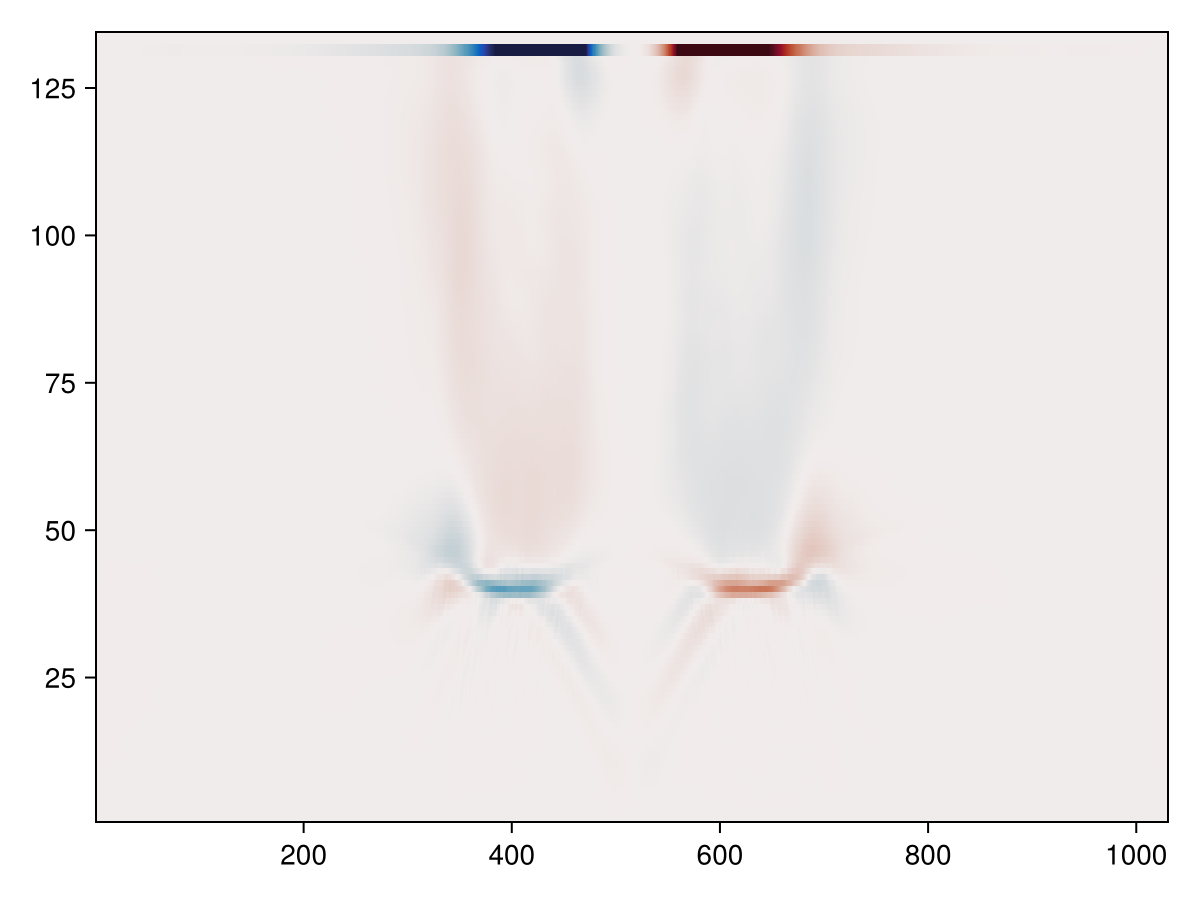

In [35]:
heatmap(imfilter(no_offset_view(file["timeseries/Lψ/$(iterations[50])"][:, 1, :]), gaussian((10, 0))), colorrange=(-100, 100), colormap=:balance)

In [ ]:
heatmap(imfilter(no_offset_view(file["timeseries/∇²ψ_tt/$(iterations[50])"][:, 1, :]), gaussian((10, 0))), colorrange=(-100, 100), colormap=:balance)

In [20]:
minimum(no_offset_view(file["timeseries/∇²ψ/$(iterations[40])"][:, 1, :]))

-298.9634494976679